###**Start**

In [ ]:
!pip install omegaconf dacite xlstm

In [ ]:
# restart notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from omegaconf import OmegaConf
from pprint import pprint
from dacite import from_dict
from dacite import Config as DaciteConfig
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

In [ ]:
from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device_

device(type='cpu')

In [ ]:
# display options
pd.set_option('display.max_columns', None)

In [ ]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# read data
df = pd.read_csv("/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/Weather.csv")

In [ ]:
df.shape

(52696, 22)

In [ ]:
df.head()

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52696 entries, 0 to 52695
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  52696 non-null  object 
 1   p (mbar)              52696 non-null  float64
 2   T (degC)              52696 non-null  float64
 3   Tpot (K)              52696 non-null  float64
 4   Tdew (degC)           52696 non-null  float64
 5   rh (%)                52696 non-null  float64
 6   VPmax (mbar)          52696 non-null  float64
 7   VPact (mbar)          52696 non-null  float64
 8   VPdef (mbar)          52696 non-null  float64
 9   sh (g/kg)             52696 non-null  float64
 10  H2OC (mmol/mol)       52696 non-null  float64
 11  rho (g/m**3)          52696 non-null  float64
 12  wv (m/s)              52696 non-null  float64
 13  max. wv (m/s)         52696 non-null  float64
 14  wd (deg)              52696 non-null  float64
 15  rain (mm)          

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [ ]:
df.replace(-9999.000000, np.nan, inplace=True)
df = df.dropna()

In [ ]:
df.replace(305.500000, np.nan, inplace=True)
df = df.dropna()

In [ ]:
df.shape

(52612, 21)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data = df.values

In [ ]:
len(data)*0.7

36828.399999999994

In [ ]:
len_df = len(data)
df_train = data[:int(len_df*0.7)]
df_valid = data[int(len_df*0.7):int(len_df*0.9)]
df_test = data[int(len_df*0.9):len_df]

In [ ]:
df_train.shape

(36828, 21)

In [ ]:
df_valid.shape

(10522, 21)

In [ ]:
df_test.shape

(5262, 21)

In [ ]:
train_scaled = scaler.fit_transform(df_train)
val_scaled = scaler.transform(df_valid)
test_scaled = scaler.transform(df_test)

In [ ]:
# import pickle

# with open('min_max_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [ ]:
train_scaled.shape

(36828, 21)

In [ ]:
val_scaled.shape

(10522, 21)

In [ ]:
test_scaled.shape

(5262, 21)

In [ ]:
window_size=24
output_size=1
target_column_index=20
batch_size=64

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_index, window_size):
        self.data = data
        self.target_index = target_index
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size, self.target_index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


train_dataset = TimeSeriesDataset(train_scaled, target_column_index, window_size)
val_dataset = TimeSeriesDataset(val_scaled, target_column_index, window_size)
test_dataset = TimeSeriesDataset(test_scaled, target_column_index, window_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 24, 21])
Labels batch shape: torch.Size([64])


###**xLSTM**

In [ ]:
xlstm_cfg = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 1
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 144
num_blocks: 5
embedding_dim: 21
dropout: 0.2
slstm_at: [0,1,2,3,4] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

In [ ]:
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
# pprint(cfg)

In [ ]:
class xlstm(torch.nn.Module):
    def __init__(self, features, config):

        super(xlstm, self).__init__()

        self.features = features

        self.xlstm_stack = xLSTMBlockStack(config)

        self.mm= nn.Linear(self.features, 1)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.xlstm_stack(x)

        x=self.mm(x[:,-1,:])

        x = self.sigmoid(x)

        return x

In [ ]:
n_features = train_features.size()[-1]
xlstm_model =  xlstm(n_features, cfg)

In [ ]:
xlstm_model

xlstm(
  (xlstm_stack): xLSTMBlockStack(
    (blocks): ModuleList(
      (0-4): 5 x sLSTMBlock(
        (xlstm_norm): LayerNorm()
        (xlstm): sLSTMLayer(
          (conv1d): CausalConv1d(
            (conv): Conv1d(21, 21, kernel_size=(4,), stride=(1,), padding=(3,), groups=21)
          )
          (conv_act_fn): SiLU()
          (fgate): LinearHeadwiseExpand(in_features=21, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (igate): LinearHeadwiseExpand(in_features=21, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (zgate): LinearHeadwiseExpand(in_features=21, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (ogate): LinearHeadwiseExpand(in_features=21, num_heads=1, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (slstm_cell): sLSTMCell_vanilla(function=slstm, hidden_size=21, num_heads=

In [ ]:
xlstm_model = xlstm_model.to(device_)

###**LSTM**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=21, hidden_size=50, num_layers=5, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [ ]:
lstm_model =  LSTMModel()

In [ ]:
lstm_model

LSTMModel(
  (lstm): LSTM(21, 50, num_layers=5, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
lstm_model = lstm_model.to(device_)

###**Training**

In [ ]:
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(xlstm_model.parameters(), lr=1e-4)

In [ ]:
train_loss_list = []
val_loss_list = []

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
def validate_xlstm(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for itr in val_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)

In [ ]:
def train_xlstm(model, train_loader, val_loader, num_epochs, patience, criterion, device):
    train_loss_list.clear()
    val_loss_list.clear()

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for itr in train_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            # print(targets)
            # print(outputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            # print(loss.item())

        train_loss_for_epoch = train_loss/len(train_loader)
        val_loss_for_epoch = validate_xlstm(model, val_loader, criterion_mse, device)

        train_loss_list.append(round(train_loss_for_epoch, 4))
        val_loss_list.append(round(val_loss_for_epoch, 4))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_for_epoch:.4f}, Val Loss: {val_loss_for_epoch:.4f}')

        early_stopping(val_loss_for_epoch)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [ ]:
train_xlstm(xlstm_model, train_loader, val_loader, 25, 5, criterion_mse, device_)

Epoch 1/25, Train Loss: 0.0186, Val Loss: 0.0162
Epoch 2/25, Train Loss: 0.0139, Val Loss: 0.0144
Epoch 3/25, Train Loss: 0.0130, Val Loss: 0.0137
Epoch 4/25, Train Loss: 0.0124, Val Loss: 0.0134
Epoch 5/25, Train Loss: 0.0120, Val Loss: 0.0134
Epoch 6/25, Train Loss: 0.0119, Val Loss: 0.0131
Epoch 7/25, Train Loss: 0.0117, Val Loss: 0.0128
Epoch 8/25, Train Loss: 0.0117, Val Loss: 0.0127
Epoch 9/25, Train Loss: 0.0116, Val Loss: 0.0125
Epoch 10/25, Train Loss: 0.0115, Val Loss: 0.0125
Epoch 11/25, Train Loss: 0.0115, Val Loss: 0.0123
Epoch 12/25, Train Loss: 0.0115, Val Loss: 0.0125
Epoch 13/25, Train Loss: 0.0114, Val Loss: 0.0123
Epoch 14/25, Train Loss: 0.0114, Val Loss: 0.0122
Epoch 15/25, Train Loss: 0.0114, Val Loss: 0.0122
Epoch 16/25, Train Loss: 0.0113, Val Loss: 0.0122
Epoch 17/25, Train Loss: 0.0113, Val Loss: 0.0121
Epoch 18/25, Train Loss: 0.0113, Val Loss: 0.0121
Epoch 19/25, Train Loss: 0.0112, Val Loss: 0.0120
Epoch 20/25, Train Loss: 0.0112, Val Loss: 0.0119
Epoch 21/

In [ ]:
def plot_learning_curves(train_loss, val_loss):
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss, "b-", label="Training loss")
    plt.plot(np.arange(1, len(val_loss) + 1), val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")

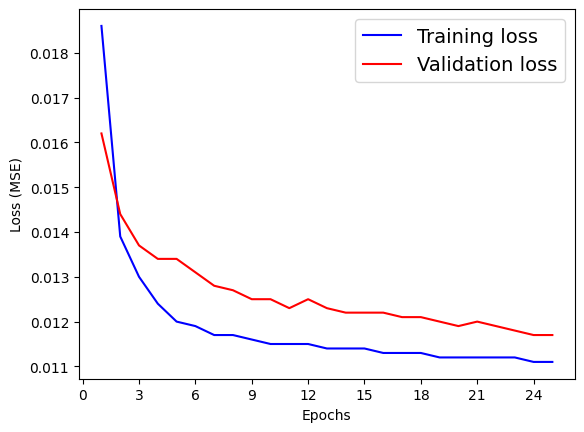

In [ ]:
plot_learning_curves(train_loss_list, val_loss_list)
plt.show()

In [ ]:
torch.save(xlstm_model.state_dict(), "/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/Weather_xLSTM__sssss.pth")

In [ ]:
# loading a model
# loaded_model =  xlstm(n_features, cfg)
# model_path = '/content/drive/Shareddrives/Projects/Research/LSTM_vs_xLSTM/Weather_xLSTM__ms.pth'
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model = loaded_model.to(device_)

In [ ]:
actual_list = []
pred_list = []

In [ ]:
def test_model(model, test_loader, criterion, device):
    actual_list.clear()
    pred_list.clear()

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for itr in test_loader:
            inputs, targets = itr[0], itr[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            out = outputs.squeeze()

            for outs in out:
              pred_list.append(outs.item())
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

In [ ]:
test_model(xlstm_model, test_loader, criterion_mse, device_)

Test Loss: 0.0121


In [ ]:
test_model(xlstm_model, test_loader, criterion_mae, device_)

Test Loss: 0.0945


In [ ]:
mx = scaler.data_max_[target_column_index]
mn = scaler.data_min_[target_column_index]
rng= scaler.data_range_[target_column_index]

In [ ]:
len(pred_list)

5238

In [ ]:
df_test.shape

(5262, 21)

In [ ]:
print(mx, mn, rng)

524.2 381.1 143.10000000000002


In [ ]:
df_test

array([[993.53,   4.44, 278.1 , ..., 508.25,  13.91, 434.  ],
       [993.4 ,   4.8 , 278.47, ..., 525.76,  14.19, 432.3 ],
       [993.29,   5.06, 278.75, ..., 536.97,  14.45, 430.8 ],
       ...,
       [978.26,   1.99, 276.88, ...,   0.  ,  13.45, 435.2 ],
       [978.26,   2.07, 276.95, ...,   0.  ,  13.47, 433.9 ],
       [978.24,   2.01, 276.89, ...,   0.  ,  13.48, 436.5 ]])

In [ ]:
X_test = df_test[window_size:, target_column_index]
actual = pd.DataFrame(X_test, columns=['actual'])

In [ ]:
actual.isnull().sum()

,0
actual,0


In [ ]:
actual['predictions'] = pred_list
actual['predictions'] = actual['predictions']*rng+mn
actual['signed_difference'] = (actual['predictions'] - actual['actual'])
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual['difference_sq'] = actual['difference'] ** 2

In [ ]:
actual

,actual,predictions,signed_difference,difference,difference_percentage,difference_sq
0,426.8,417.895004,-8.904996,8.904996,2.086456,79.298953
1,426.6,418.175294,-8.424706,8.424706,1.974849,70.975676
2,424.5,418.327595,-6.172405,6.172405,1.454041,38.098582
3,424.5,418.420643,-6.079357,6.079357,1.432122,36.958586
4,423.6,418.569285,-5.030715,5.030715,1.187610,25.308094
...,...,...,...,...,...,...
5233,433.0,423.005405,-9.994595,9.994595,2.308221,99.891938
5234,439.6,423.236488,-16.363512,16.363512,3.722364,267.764525
5235,435.2,424.115232,-11.084768,11.084768,2.547051,122.872082
5236,433.9,424.103568,-9.796432,9.796432,2.257763,95.970080


In [ ]:
# results
print("Error, less than or equal to 5%: ", round((actual['difference_percentage'] <= 5).sum()/actual.shape[0]*100, 2), "%")
print("Error, less than or equal to 10%: ", round((actual['difference_percentage'] <= 10).sum()/actual.shape[0]*100, 2), "%")
print("MSE: ", round(actual['difference_sq'].mean(), 2))
print("RMSE: ", round(math.sqrt(actual['difference_sq'].mean()), 2))
print("MAE: ", round(actual['difference'].mean(), 2))
print("Max error: ", round(actual['difference'].max(), 2))

Error, less than or equal to 5%:  94.5 %
Error, less than or equal to 10%:  100.0 %
MSE:  214.55
RMSE:  14.65
MAE:  13.24
Max error:  42.36


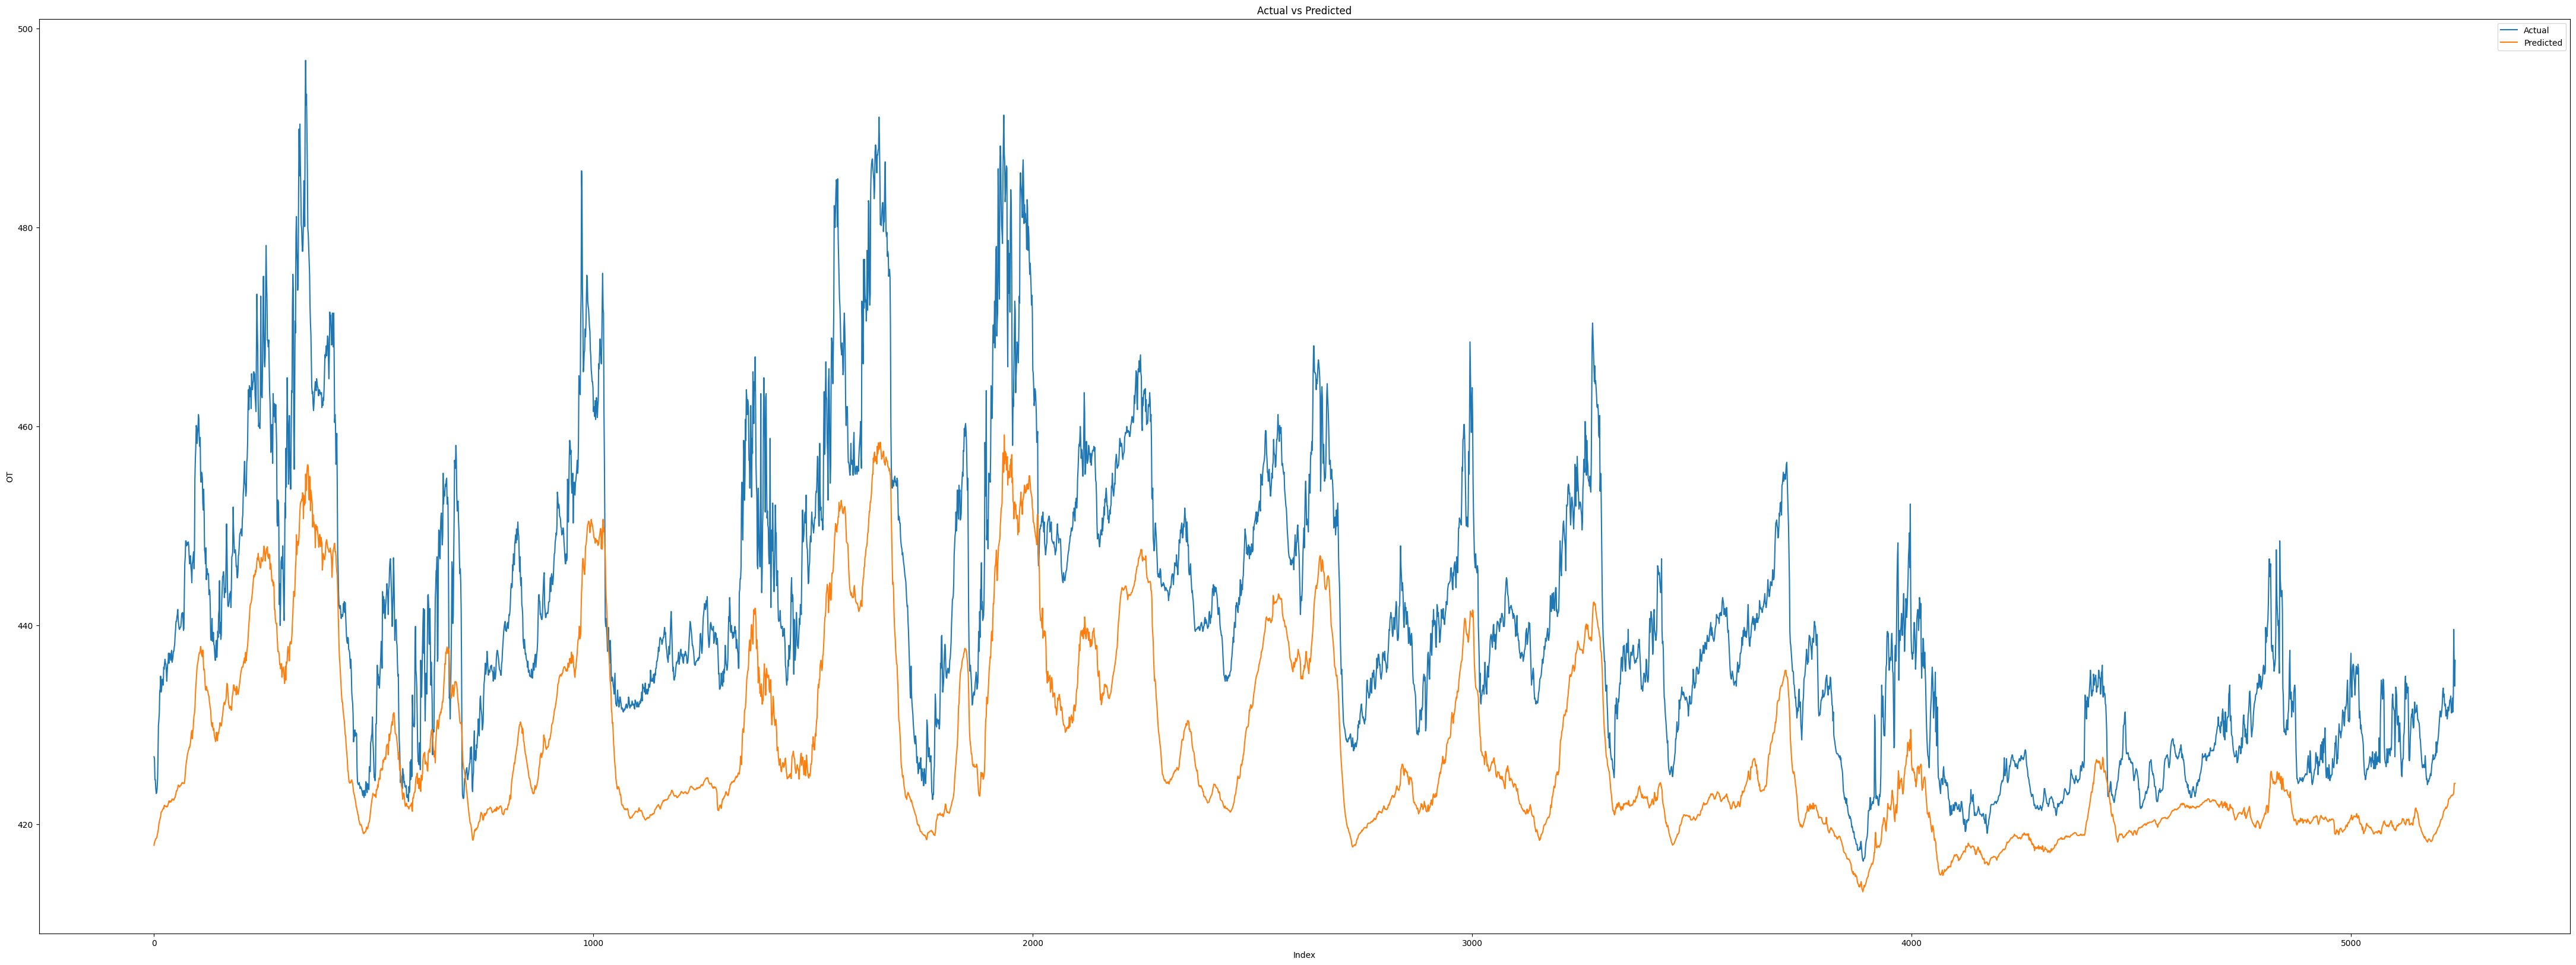

In [ ]:
plt.figure(figsize=(55, 20))
sns.lineplot(data=actual, x=actual.index, y="actual", label="Actual")
sns.lineplot(data=actual, x=actual.index, y="predictions", label="Predicted")
plt.xlabel('Index')
plt.ylabel('OT')
plt.title('Actual vs Predicted')
plt.autoscale(enable=True)
plt.legend()
plt.show()